In [ ]:
# default_exp puf_functions

# puf_functions

> Analysis of physically unclonable function properties of hybrid boolean networks, including measures of chaos such as the lyapunov exponent, and entropic measures such as inter and intra network variation. See https://ieeexplore.ieee.org/document/9380284.

In [ ]:
#hide
from nbdev import *
from nbdev.imports import *
from nbdev.export import *
from nbdev.sync import *
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import warnings
with warnings.catch_warnings(): #ignore warnings
    warnings.simplefilter("ignore")
    import networkx as nx
    import numpy as np
    import sidis
    rng=sidis.RNG(0)
    import matplotlib.pyplot as plt
    import typing
    from typing import Optional, Tuple, Dict, Callable, Union, Mapping, Sequence, Iterable, Hashable, List, Any
    from collections import namedtuple
    import einops
    import numba
    from numba import njit
    from scipy import stats
    import scipy.optimize as sciopt
    
    from networkm.graph_functions import *
    from networkm.model_functions import *
    from networkm.network_class import *

In [ ]:
#export
def puf_statistics(responses : np.ndarray,
                   shape : str = 'challenge repeat time instance node'
                  ) -> Tuple[Union[np.ndarray,float,int]]:
    '''
    Given an array of `responses` of a given `shape`, calculate the inter and intra
    PUF statistics mu_inter and mu_intra and their standard deviations over time.
    Return these as arrays over time, as well as their maximum separation mu_opt
    and the time at which this occurs t_opt. 
    `shape` must be a permutation of the words 'challenge repeat time instance node'
    and describes the input shape of the array.
    '''
    resp=einops.rearrange(responses,shape+
                          '-> challenge repeat time instance node').astype(float)
    n_distinct=resp.shape[0]
    n_repeat=resp.shape[1]
    measure_time=resp.shape[2]
    n_synth=resp.shape[3]
    n=resp.shape[4]
    #Number of pairwise combinations for inter and intra calculations.
    l_intra=n_repeat*(n_repeat-1)/2
    l_inter=n_synth*(n_synth-1)/2
    #Pairwise differences of timeseries from responses used for comparison.
    pdt_intra=np.zeros((n_distinct,n_synth,int(l_intra),measure_time))
    pdt_inter=np.zeros((n_distinct,n_repeat,int(l_inter),measure_time))
    #Loop over each pairwise combination and form fractional hamming distances at each time.
    for i in range(n_distinct):
        for g in range(n_synth):
            l=0
            for j in range(n_repeat):
                for k in range(j+1,n_repeat):
                    pdt_intra[i,g,l]=np.sum(abs(resp[i,j,:,g,:]-resp[i,k,:,g,:]),axis=-1)/n
                    l+=1
        for g in range(n_repeat):
            l=0
            for j in range(n_synth):
                for k in range(j+1,n_synth):
                    pdt_inter[i,g,l]=np.sum(abs(resp[i,g,:,j,:]-resp[i,g,:,k,:]),axis=-1)/n
                    l+=1
    #Compute means on a per-device and overall level.
    #Intra block below. Copies along axes for quick vector calculations.
    mu_intra_per_device=np.mean(pdt_intra,axis=(0,2))
    mu_intra_per_device_copy=np.repeat(\
        np.repeat(mu_intra_per_device[:,np.newaxis,:],\
            l_intra,axis=1)[np.newaxis,:],n_distinct,axis=0)
    sigma_intra_per_device= np.sqrt(np.mean((np.square(pdt_intra-mu_intra_per_device_copy)),axis=(0,2)))
    mu_intra=np.mean(mu_intra_per_device,axis=0)
    sigma_intra=np.mean(sigma_intra_per_device,axis=0)
    #Inter block below. Copies along axes for quick vector calculations.
    mu_inter_per_device=np.mean(pdt_inter,axis=(0,2))
    mu_inter_per_device_copy=np.repeat(np.repeat(\
        mu_inter_per_device[:,np.newaxis,:],l_inter,axis=1)[np.newaxis,:],\
            n_distinct,axis=0)
    sigma_inter_per_device= np.sqrt(np.mean((np.square(pdt_inter-mu_inter_per_device_copy)),axis=(0,2)))
    mu_inter=np.mean(mu_inter_per_device,axis=0)
    sigma_inter=np.mean(sigma_inter_per_device,axis=0)
    #Find optimum measurement time and save time series.
    t_opt=np.argmin(mu_intra-mu_inter)
    mu_opt=mu_inter[t_opt]-mu_intra[t_opt]
    return mu_inter,mu_intra,sigma_inter,sigma_intra,mu_opt,t_opt

In [ ]:
#export
def bool_lyapunov(responses : np.ndarray,
                  window : int = 5,
                  shape : str = 'challenge repeat time node'
                 ) -> Tuple[np.ndarray]:
    """
    Boolean timeseries Lyapunov exponent calculator.
    Takes as input the time series of PUF responses
    and calculates the maximum Lyapunov exponent to determine if the system is chaotic.
    Args:
        responses: array of PUF responses for a single instance
        window: Temporal window length for comparison of Boolean distance between time series.
        shape: input shape of PUF responses for a single instance
    """
    T=window
    resp=einops.rearrange(responses,shape+
                          '-> challenge repeat time node').astype(float)
    nrp= resp.shape[1] #number of reps
    nch= resp.shape[0] #number of challenges
    measure_time=resp.shape[2]
    n=resp.shape[-1]
    #We loop over pairwise combinations of timeseries comparisons and compute the
    #average Boolean distance within the window length.
    clist=[]
    for c in range(nch):
        ilist=[]
        for i in range(1,nrp):
            tlist=[]
            for t in range(measure_time-T):
                d=np.sum(abs(resp[c,i,t:t+T]-resp[c,0,t:t+T]))/(n*T)
                if d!=0:
                    first_t=t
                    break
                else:
                    first_t=0
            for t in range(first_t,measure_time-T):
                d=np.sum(abs(resp[c,i,t:t+T]-resp[c,0,t:t+T]))/(n*T)
                tlist+=[d]
            if tlist!=[]:
                ilist+=[tlist]
        if ilist!=[]:
            clist+=[ilist]

    avgln=[0 for t in range(measure_time-T)]
    tcounterlist=[0 for t in range(measure_time-T)]
    longesttime=-1
    for c in range(nch):
        for i in range(len(clist[c])):
            for t in range(len(clist[c][i])):
                tcounterlist[t]+=1
                avgln[t]+=np.log(clist[c][i][t]) if clist[c][i][t]!=0 else np.log(0.01)
                longesttime=t if t>longesttime else longesttime

    avgln=avgln[:longesttime+1]
    tcounterlist=tcounterlist[:longesttime+1]

    for t in range(len(avgln)):
        avgln[t]=avgln[t]/tcounterlist[t]

    sigmaln=[0 for t in range(len(avgln))]
    for c in range(nch):
        for i in range(len(clist[c])):
            for t in range(len(clist[c][i])):
                xi=np.log(clist[c][i][t]) if clist[c][i][t]!=0 else np.log(0.01)
                sigmaln[t]+=(xi-avgln[t])**2

    for t in range(len(avgln)):
        sigmaln[t]=np.sqrt(sigmaln[t]/(tcounterlist[t]-1))
    
    return avgln,sigmaln

In [ ]:
#export
def lya_fit(avgln,sigmaln,lstart=0,lend=5):
    """
    Fits average logarithm of boolean distances calculated in lya() function.
    Calculates resulting maximum lyapunov exponent.
    Args:
        lstart: Start of linear fit.
        lend: End of linear fit.
    """
    linearstart=lstart
    linearend=lend
    xdata=np.arange(linearstart,linearend+1)
    ydata=np.asarray(avgln[linearstart:linearend+1])
    sdata=np.asarray(sigmaln[linearstart:linearend+1])
    def lin(x,m,b):
        return m*x+b
    popt, pcov = sciopt.curve_fit(lin, xdata, ydata, sigma=sdata, absolute_sigma=True)
    m=popt[0]
    b=popt[1]
    p_sigma = np.sqrt(np.diag(pcov))
    m_sigma = p_sigma[0]
    residuals = ydata- lin(xdata, m,b)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    lya_b=b
    lya_max=m
    lya_max_err=m_sigma
    return lya_max,lya_max_err

In [ ]:
#export
@njit
def booleanize(vn, threshold=0.5):
    '''
    Convert the numpy array `vn` into a bitstream
    according to `threshold`; values of `vn>=threshold`
    will be set to `1`, and values of `vn<threshold`
    will be set to `0`. If `threshold` is not supplied,
    it defaults to halfway between the range of `vn`.
    '''
    if threshold is None:
        threshold=(np.max(vn)-np.min(vn))/2
    B=np.zeros(vn.shape).astype(vn.dtype)
    for s in np.ndindex(vn.shape):
        if vn[s]>=threshold:
            B[s]+=1.
    return B

In [ ]:
booleanize(np.array([[0,0.5,1,0.7,0.3],[0,0.5,1,0.7,0.3]]))

array([[0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0.]])

In [ ]:
#export
def ensemble(classes = 3,
             instances = 3,
             challenges = 3,
             repeats = 3,
             inter_variation = 0.1,
             T = 15,
             dt = 0.01,
             hold = (rng.normal,1,0.1),
             noise = 0.01,
             decimation = None,
             g = (nx.random_regular_graph,3,16),
             a = (rng.normal,20,2),
             tau = (rng.normal,1,0.1),
             f = XOR,
             delay = (rng.random,0,1),
             edge_replacements = dict(
                 lengths = 1,
                 delay = (rng.random,0,0.5),
                 node_attrs = dict(
                     a = (rng.normal,20,2),
                     tau = (rng.normal,0.5,0.05),
                     f = MPX)
             ),
             return_classes = False
            ):
    if decimation is None:
        decimation=int(1/dt)
    perturb = lambda a: (a*(1.+rng.random(-inter_variation/2.,inter_variation/2.,shape=a.shape))
                        ).astype(a.dtype)
    
    models = [None for c in range(classes)]
    hold_times = [None for c in range(classes)]
    iterators = [None for c in range(classes)]
    predecessors = [None for c in range(classes)]
    
    time_delays = [[None for i in range(instances)] for c in range(classes)]
    sigmoid_constants = [[None for i in range(instances)] for c in range(classes)]
    time_constants = [[None for i in range(instances)] for c in range(classes)]

    for c in range(classes):
        graph = parse_kwargs(g=g)['g']
        N = len(graph) #assume all graphs same len
        hold_args = tuple(list(hold)+[dict(shape=N)])
        model = BooleanNetwork(g=graph,
                               init=None,
                               hold=parse_kwargs(k=hold_args)['k'],
                               a=a,
                               T=T,
                               dt=dt,
                               noise=noise,
                               f=f,
                               tau=tau,
                               delay=delay,
                               edge_replacements=edge_replacements,
                               plot=False)
        models[c] = model
        hold_times[c] = model.hold
        iterators[c] = model.itr
        predecessors[c] = model.predar
        
        for i in range(instances):
            time_delays[c][i] = perturb(model.delay)
            sigmoid_constants[c][i] = perturb(model.a)
            time_constants[c][i] = perturb(model.tau)
            
    iterators = np.array(iterators)
    predecessors = np.array(predecessors)
    time_delays =  np.array(time_delays)
    sigmoid_constants = np.array(sigmoid_constants)
    time_constants = np.array(time_constants)
    hold_times = np.array(hold_times)
    
    initial_conditions = np.empty((challenges,repeats,len(model)))
    for h in range(challenges): #assume length of all classes equal 
        initial_conditions[h,:],_=bool_initial_conditions(model,
                    init=rng.random(0,1,absval=True,asint=True,shape=N),
                    hold=None,
                    steady=True)

    int_type = np.int64
    float_type = np.longdouble
    data = dict(
        iterator_matrix=iterators.astype(int_type),
        time_delay_matrix=time_delays.astype(int_type),
        sigmoid_constant_matrix=sigmoid_constants.astype(float_type),
        time_constant_matrix=time_constants.astype(float_type),
        predecessor_matrix=predecessors.astype(int_type),
        initial_condition_matrix=initial_conditions.astype(float_type),
        hold_time_matrix=hold_times.astype(int_type),
        dt=dt,
        noise_scale=noise,
        T=T,
        N=len(model),
        decimation=decimation
    )
    if return_classes:
        return models,data
    else:
        return data

In [ ]:
#export
@njit
def query_rise(iterator_matrix,
               time_delay_matrix,
               sigmoid_constant_matrix,
               time_constant_matrix,
               predecessor_matrix,
               initial_condition_matrix,
               hold_time_matrix,
               dt,
               T,
               N,
               noise_scale,
               decimation
              ):
    classes=iterator_matrix.shape[0]
    challenges=initial_condition_matrix.shape[0]
    repeats=initial_condition_matrix.shape[1]
    instances=time_delay_matrix.shape[1]

    responses = np.zeros((classes,instances,challenges,repeats,T,N))

    for c,q,h,r in np.ndindex(responses.shape[:-2]): #class,inst,chal,rep
        iterator=iterator_matrix[c]
        time_delays=time_delay_matrix[c,q]
        sigmoid_constants=sigmoid_constant_matrix[c,q]
        time_constants=time_constant_matrix[c,q]
        predecessors=predecessor_matrix[c]
        initial_conditions=initial_condition_matrix[h,r]
        hold_times=hold_time_matrix[c]   
        x=np.zeros((int(T/dt),N)).astype(np.longdouble)
        dx=np.zeros(x.shape[-1]).astype(np.longdouble)
        for t in range(x.shape[0]-1):
            noise=np.empty(x.shape[1])
            for n in range(x.shape[1]):
                noise[n]=np.random.random()
            noise=noise*noise_scale
            edge_index=0
            if t<max(hold_times):
                for n in range(x.shape[-1]):
                    if hold_times[n]>=t:
                        x[t,n]=initial_conditions[n]
            for i in range(len(iterator)): 
                n1,n2,deg,mask=iterator[i]
                d=-time_delays[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
                d+=t
                p=predecessors[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
                a=sigmoid_constants[n1:n2].reshape((n2-n1,1))
                edge_index+=(n2-n1)*deg
                y=np.zeros((n2-n1,deg))#.astype(np.longdouble)
                for k in range(n2-n1):
                    for j in range(deg):
                        de=d[k,j]
                        pr=p[k,j]
                        y[k,j]=x[de,pr]
                y=sigmoid(x=y,a=a)
                dx[n1:n2]=BOOL(y,mask)
            dx=sigmoid(dx,sigmoid_constants)
            dxdt=(-x[t]+dx+noise)/time_constants
            x[t+1]=x[t]+dt*dxdt
        
        responses[c,q,h,r]=x[::decimation]
                
    return responses

In [ ]:
#export
@njit
def query_fall(iterator_matrix,
               time_delay_matrix,
               sigmoid_constant_matrix,
               time_constant_matrix,
               predecessor_matrix,
               initial_condition_matrix,
               hold_time_matrix,
               dt,
               T,
               N,
               noise_scale,
               decimation
              ):
    classes=iterator_matrix.shape[0]
    challenges=initial_condition_matrix.shape[0]
    repeats=initial_condition_matrix.shape[1]
    instances=time_delay_matrix.shape[1]

    responses = np.zeros((classes,instances,challenges,repeats,T,N))

    for c,q,h,r in np.ndindex(responses.shape[:-2]): #class,inst,chal,rep
        iterator=iterator_matrix[c]
        time_delays=time_delay_matrix[c,q]
        sigmoid_constants=sigmoid_constant_matrix[c,q]
        time_constants=time_constant_matrix[c,q]
        predecessors=predecessor_matrix[c]
        initial_conditions=initial_condition_matrix[h,r]
        hold_times=hold_time_matrix[c]   
        x=np.zeros((int(T/dt),N)).astype(np.longdouble)
        dx=np.zeros(x.shape[-1]).astype(np.longdouble)
        for t in range(x.shape[0]-1):
            noise=np.empty(x.shape[1])
            for n in range(x.shape[1]):
                noise[n]=np.random.random()
            noise=noise*noise_scale
            edge_index=0
            if t<max(hold_times):
                for n in range(x.shape[-1]):
                    if hold_times[n]>=t:
                        x[t,n]=initial_conditions[n]
            for i in range(len(iterator)): 
                n1,n2,deg,mask=iterator[i]
                d=-time_delays[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
                d+=t
                p=predecessors[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
                a=sigmoid_constants[n1:n2].reshape((n2-n1,1))
                edge_index+=(n2-n1)*deg
                y=np.zeros((n2-n1,deg))#.astype(np.longdouble)
                for k in range(n2-n1):
                    for j in range(deg):
                        de=d[k,j]
                        pr=p[k,j]
                        y[k,j]=x[de,pr]
                y=sigmoid(x=y,a=a)
                dx[n1:n2]=BOOL(y,mask)
            dx=sigmoid(dx,sigmoid_constants)
            tau=time_constants[:,0]+(time_constants[:,1]-time_constants[:,0]
                                    )*sigmoid(x[t],sigmoid_constants)
            dxdt=(-x[t]+dx+noise)/tau
        
        responses[c,q,h,r]=x[::decimation]
                
    return responses

In [ ]:
#export
def analyze(responses,
           shape = 'design instance challenge repeat time node',
           window = 5
          ):
    responses = einops.rearrange(responses,
                                 shape+'->design instance challenge repeat time node')
    classes,instances,challenges,repeats,T,N=responses.shape
    boolean = booleanize(responses).astype(int)
    mu_inter=np.empty((classes,T,2))
    mu_intra=np.empty((classes,T,2))
    delta_mu=np.empty((classes,2))
    t_opt=np.empty((classes))
    
    for s in range(responses.shape[0]):
        muinter,muintra,dmuinter,dmuintra,muopt,topt=puf_statistics(
            responses=boolean[s],shape='instance challenge repeat time node')
        mu_inter[s,:,0]=muinter
        mu_inter[s,:,1]=dmuinter
        mu_intra[s,:,0]=muintra
        mu_intra[s,:,1]=dmuintra
        t_opt[s]=topt
        delta_mu[s,0]=muopt
        delta_mu[s,1]=np.sqrt((muintra[topt]*dmuinter[topt])**2+(muinter[topt]*dmuintra[topt])**2)

        
    log_dist=np.empty((classes,instances,T-window,2))
    lyapunov=np.empty((classes,instances,2))
    
    for s in np.ndindex(responses.shape[:2]):
        avgln,sigmaln=bool_lyapunov(boolean[s],window,shape= 'challenge repeat time node')
        lya,dlya=lya_fit(avgln,sigmaln,lstart=0,lend=int(T/2))
        a=np.array([avgln,sigmaln])
        a=a.T
        log_dist[s]=a
        a=np.array([lya,dlya])
        a=a.T
        lyapunov[s]=a
    
    return dict(mu_inter=mu_inter,mu_intra=mu_intra,delta_mu=delta_mu,t_opt=t_opt,
               log_dist=log_dist,lyapunov=lyapunov)
        

In [ ]:
#export
@sidis.timer
def query(classes = 3,
         instances = 3,
         challenges = 3,
         repeats = 3,
         inter_variation = 0.1,
         decimation = None,
         g = (nx.random_regular_graph,3,16),
         a = (rng.normal,20,2),
         tau = (rng.normal,1,0.1),
         f = XOR,
         delay = (rng.random,0,1),
         edge_replacements = dict(
             lengths = 1,
             delay = (rng.random,0,0.5),
             node_attrs = dict(
                 a = (rng.normal,20,2),
                 tau = (rng.normal,0.5,0.05),
                 f = MPX)
         ),
         T = 15,
         dt = 0.01,
         hold = (rng.normal,1,0.1),
         noise = 0.01,
         enroll = True
         ):
    model_data = ensemble(**{k:v for k,v in locals().items() if k!='enroll'})
    if model_data['time_constant_matrix'].shape[-1]==2:
        integrator = query_fall
    else:
        integrator = query_rise
    response = integrator(**model_data)
    if enroll:
        stats = analyze(response)
        return response,stats
    else:
        return response

In [ ]:
resp,data=query(classes=3,challenges = 3,
          repeats= 3,
          instances =3,
          hold = (rng.normal,1,0.1),
          T = 25,
          dt = 0.01,
          noise = 0.1,
          decimation = None,
          inter_variation = 0.1,
          g = (nx.random_regular_graph,3,256),
          a = np.inf,
          tau = (rng.normal,1,0.1),
          f = XOR,
          delay = (rng.random,0,3),
          edge_replacements = dict(
              lengths = 1,
              delay = (rng.random,0,1),
              node_attrs = dict(
                  a = np.inf,
                  tau = (rng.normal,0.5,0.05),
                  f = MPX
              )
          ),
         enroll = True
         )

query : Elapsed time: 13.5413 seconds


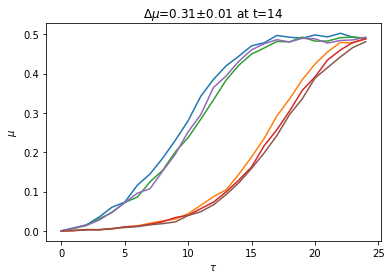

In [ ]:
for puf_class in range(3):
    mu_inter,mu_intra=data['mu_inter'][puf_class,...,0],data['mu_intra'][puf_class,...,0]
    plt.plot(mu_inter)
    plt.plot(mu_intra)

deltamu=np.mean(data['delta_mu'],axis=0)
topt=np.rint(np.mean(data['t_opt'],axis=0))
title=f'$\Delta\mu$={deltamu[...,0]:.2f}$\pm${deltamu[...,1]:.2f} at t={topt:.0f}'
plt.title(title)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\mu$')
plt.show()

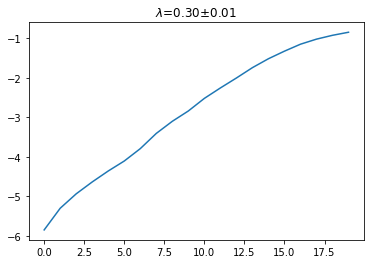

In [ ]:
puf_class=0
puf_inst=0
log,lya=data['log_dist'][puf_class,puf_inst,:,0],data['lyapunov'][puf_class,puf_inst,0]
err=data['lyapunov'][puf_class,puf_inst,1]
title=f'$\lambda$={lya:.2f}$\pm${err:.2f}'
plt.title(title)
plt.plot(log)

In [ ]:
#sidis.refresh()